In [37]:
from u import *
from pexps.ut import *
from IPython.display import display, HTML

Code = Path.env('F')
Results = Path.env('R')

sys.path.append(Code)
from env import E

def load_results(plots_dir, path_to_key_fn):
    eval_paths = {}
    traj_paths = {}
    for path in plots_dir.glob('*'):
        key = path_to_key_fn(path)
        if (ev_path := path / 'evaluation.csv').exists():
            eval_paths[key] = ev_path
        if (tr_path := path / 'trajectories.npz').exists():
            traj_paths[key] = tr_path
    return eval_paths, traj_paths

def split_trajectories(df, min_len=0):
    idxs, = np.where(df.step[:-1].values > df.step[1:].values)
    idxs = [0, *(idxs + 1), len(df)]
    return [df.iloc[start: end] for start, end in zip(idxs[:-1], idxs[1:]) if df.step.iloc[end - 1] >= min_len]

# Single Ring

In [38]:
SingleRingPlots = Results / 'single_ring/plots'
def single_ring_key(path):
    method, circ = re.match('(.+) circumference=(\d+)', path.name).groups()
    return method, int(circ)
eval_paths, traj_paths = load_results(SingleRingPlots, single_ring_key)

eval_circumferences = np.arange(230, 271, 10)
sim_step = 0.1
warmup_steps = 2000

In [39]:
n_veh = 22
L_veh = 5
a = 1
b = 1.5
s0 = 2
v0 = 30
T = 1
delta = 4

unstable = []
for L in eval_circumferences:
    sf = (L - L_veh * n_veh) / n_veh
    accel_fn = lambda v: a * (1 - (v / v0) ** delta - ((s0 + v * T) / sf) ** 2)
    sol = scipy.optimize.root(accel_fn, 0)
    vf = sol.x.item()
    sstarf = s0 + vf * T
    unstable.append(vf)

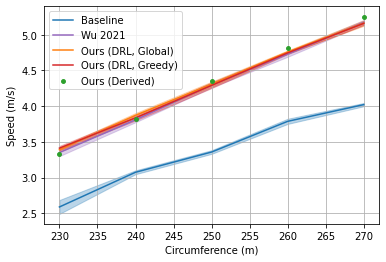

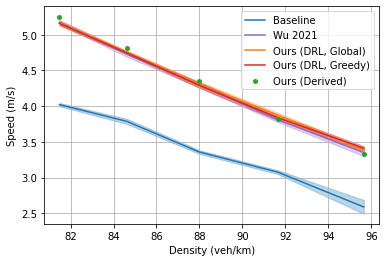

In [40]:
xs_circ = eval_circumferences
xs_density = n_veh / eval_circumferences * 1000
for xs, xlabel in (xs_circ, 'Circumference (m)'), (xs_density, 'Density (veh/km)'):
    fig = plt.figure(figsize=(6, 4))
    plt.ylabel('Speed (m/s)')
    plt.xlabel(xlabel)
    
    for i, label in enumerate([
        'Baseline',
        'Wu 2021',
        'Ours (DRL, Global)',
        'Ours (DRL, Greedy)',
        'Ours (Derived)',
    ]):
        means, stds = [], []
        for circ in xs_circ:
            df = eval_paths[label, circ].load()
            means.append(df.speed.mean())
            stds.append(df.speed.std())
        means, stds = np.array(means), np.array(stds)
        color = ['C0', 'C4', 'C1', 'C3', 'C2'][i]
        if 'Derived' in label:
            plt.errorbar(xs, means, yerr=stds, ls="none", zorder=100, color=color)
            plt.scatter(xs, means, label=label, s=15, zorder=100, color=color)
        else:
            plt.plot(xs, means, label=label, color=color)
            plt.fill_between(xs, means - stds, means + stds, alpha=0.3, color=color)
    plt.legend()
    plt.grid()
#     plt.xlim([xs.min(), xs.max()])
    plt.show()

In [41]:
cache = {}

In [42]:
for k, path in traj_paths.items():
    if k not in cache:
        npz = np.load(path)
        cache[k] = trajectories = split_trajectories(pd.DataFrame({k: npz[k] for k in npz.files}), 8000)
        assert len(trajectories) == 10

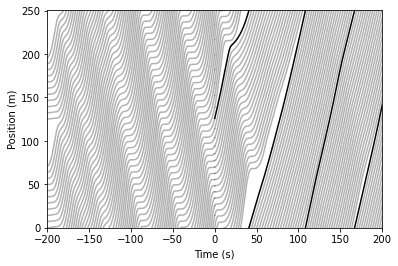

In [45]:
circ = 250
sim_step = 0.1
warmup_steps = 2000
label = 'Ours (DRL, Global)'

plt.figure(figsize=(6, 4))
path = traj_paths[label, circ]
xml = E.from_path(path.replace('.npz', '.net.xml'))
lanes = {e[0].id: Namespace(**e[0]) for e in xml if e._name == 'edge'}

df = cache[label, circ][0]
df.id = df.id.astype(int)
lane_order = [':bottom_0_0', 'right_0', ':top_0_0', 'left_0']
lane_lengths = [float(lanes[k].length) for k in lane_order]
total_length = sum(lane_lengths)
pos_offset = dict(zip(lane_order, np.cumsum(lane_lengths) - lane_lengths))
df['is_warmup'] = df.step < warmup_steps
for (id, is_warmup), vehs in df.groupby(['id', 'is_warmup']):
    position = vehs.apply(lambda row: pos_offset[row.lane_id] + row.lane_position, axis=1).values
    breaks = position[:-1] > position[1:]
    idxs, = breaks.nonzero()
    for steps, pos in zip(np.split(vehs.step, 1 + idxs), np.split(position, 1 + idxs)):
        plt.plot((steps - warmup_steps) * sim_step, pos, color='black', alpha=1 if id == 0 and not is_warmup else 0.3)
plt.ylabel('Position (m)')
plt.xlabel('Time (s)')
plt.xlim([-warmup_steps * sim_step, 200])
plt.ylim([0, total_length])
plt.show()

# Double Ring

In [46]:
DoubleRingPlots = Results / 'double_ring/plots'
def double_ring_key(path):
    method, circ = re.match('(.+) circumference=(\d+)', path.name).groups()
    return method, int(circ)
eval_paths, traj_paths = load_results(DoubleRingPlots, double_ring_key)

eval_circumferences = range(240, 261, 5)
sim_step = 0.1
warmup_steps = 2000

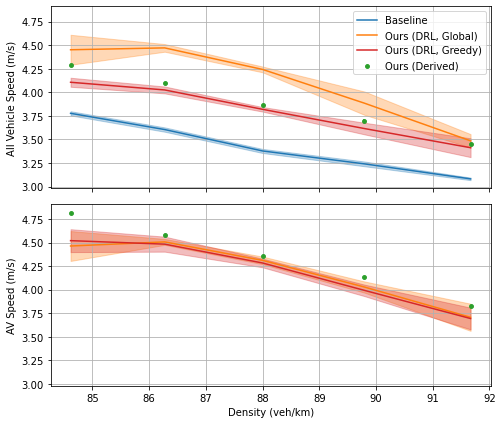

In [47]:
skip_stat_steps = 5000
fig, axes = plt.subplots(2, 1, figsize=(7, 6), sharex=True, sharey=True)
for rl_only, ax in zip([
    False,
    True,
], axes):
    color_map = [0, 1, 3, 2]
    for i, label in enumerate([
        'Baseline',
        'Ours (DRL, Global)',
        'Ours (DRL, Greedy)',
        'Ours (Derived)',
    ]):
        if rl_only and label == 'Uncontrolled':
            continue
        means, stds = [], []
        circs = np.arange(240, 261, 5)
        densities = 44 / 2 / circs * 1000
        xs = densities
        for circ in circs:
            df = eval_paths[label, circ].load()
            speeds = df.speed_rl if rl_only else df.speed
            mean, std = speeds.mean(), speeds.std()
            means.append(mean)
            stds.append(std)
        means, stds = np.array(means), np.array(stds)
        if 'Derived' in label:
            ax.errorbar(xs, means, yerr=stds, ls="none", color=f'C{color_map[i]}', zorder=100)
            ax.scatter(xs, means, label=label, color=f'C{color_map[i]}', s=15, zorder=100)
        else:
            ax.plot(xs, means, label=label, color=f'C{color_map[i]}')
            ax.fill_between(xs, means - stds, means + stds, alpha=0.3, color=f'C{color_map[i]}')
    not rl_only and ax.legend()
    ax.grid()
    rl_only and ax.set_xlabel('Circumference (m)' if xs is circs else 'Density (veh/km)')
    ax.set_ylabel('AV Speed (m/s)' if rl_only else 'All Vehicle Speed (m/s)')
plt.tight_layout()
plt.show()

In [48]:
cache = {}

In [49]:
for k, path in traj_paths.items():
    if k not in cache:
        npz = np.load(path)
        cache[k] = trajectories = split_trajectories(pd.DataFrame({k: npz[k] for k in npz.files}), 8000)
        assert len(trajectories) == 10

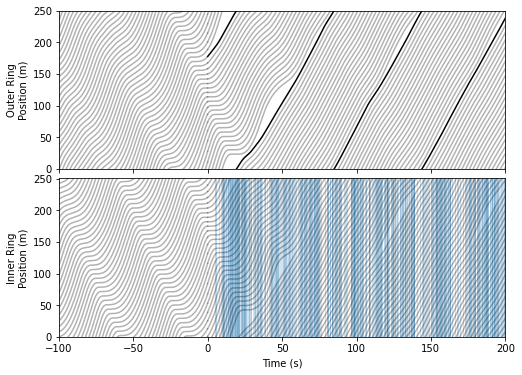

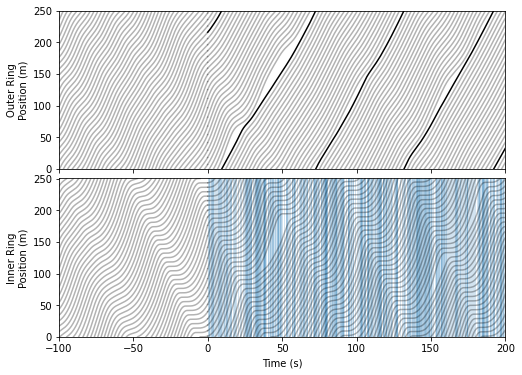

In [52]:
for label in [
    'Ours (DRL, Global)',
    'Ours (DRL, Greedy)',
]:
    circ = 250
    xml = E.from_path(traj_paths['Baseline', circ].replace('.npz', '.net.xml'))
    lanes = {lane.id: Namespace(**lane) for e in xml for lane in e if e._name == 'edge'}
    lane_orders = [
        [':bottom_0_0', 'right_0', ':top_0_0', 'left_0'],
        [':bottom_0_1', 'right_1', ':top_0_1', 'left_1'],
    ]
    pos_offset = {}
    for lane_order in lane_orders:
        lane_lengths = [float(lanes[k].length) for k in lane_order]
        total_length = sum(lane_lengths)
        pos_offset.update(dict(zip(lane_order, np.cumsum(lane_lengths) - lane_lengths)))
    df = cache[label, circ][0]
    df['is_warmup'] = df.step < warmup_steps
    fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 6))
    for ax, lane_order, ylabel in zip(axes, lane_orders, ('Outer', 'Inner')):
        for (id, is_warmup), vehs in df.loc[df.lane_id.isin(lane_order)].groupby(['id', 'is_warmup']):
            is_rl = not is_warmup and vehs.type.iloc[0] == 'rl'
            position = vehs.apply(lambda row: pos_offset[row.lane_id] + row.lane_position, axis=1).values
            step = vehs.step
            breaks = (position[:-1] > position[1:]) | (step[1:].values - step[:-1].values != 1)
            idxs, = breaks.nonzero()
            for steps, pos in zip(np.split(vehs.step, 1 + idxs), np.split(position, 1 + idxs)):
                xs = (steps - warmup_steps) * sim_step
                ax.plot(xs, pos, color='black', alpha=1 if is_rl else 0.3)
                if is_rl:
                    for i_t in [*lif(pos[0] > 1, 0), *lif(total_length - pos[-1] > 1, -1)]:
                        miny, maxy = (0, pos[i_t]) if ylabel == 'Outer' else (pos[i_t], total_length)
                        x = xs.iloc[i_t]
                        if x > 0:
                            ax.vlines(x=x, ymin=miny, ymax=maxy, color='red', linestyle='-', linewidth=1, zorder=0)
        ax.set_ylabel(f'{ylabel} Ring\nPosition (m)')
        ax.set_ylim([0, total_length])
    agent_npz = traj_paths[label, circ].replace('.npz', '_agent.npz').load()
    agent_info = split_trajectories(pd.DataFrame({k: agent_npz[k] for k in agent_npz.files}))[0]
    rl_df = df.loc[df.type == 'rl'].set_index('step')
    prev_to_lane = 0
    prev_lane = 0
    prev_step = 0
    durations = []
    
    lane_intents = agent_info.lane_change.fillna(0).astype(int)
    lanes = rl_df['lane_id'].apply(lambda x: int(x[-1])).loc[lane_intents.index]
    step = -warmup_steps
    for (lane, lane_intent), group in groupby(zip(lanes, lane_intents)):
        length = len(list(group))
        if lane != lane_intent:
            axes[lane_intent].axvspan(step * sim_step, (step + length) * sim_step, alpha=0.2, color='C0', linewidth=1)
            durations.append(length)
        step += length
    plt.xlabel('Time (s)')
    plt.subplots_adjust(hspace=0.06)
    plt.xlim([-1000 * sim_step, 2000 * sim_step])

    plt.show()

# Figure Eight

In [53]:
FigureEightPlots = Results / 'figure_eight/plots'
def figure_eight_key(path):
    method, radius = re.match('(.+) radius=(\d+)', path.name).groups()
    return method, int(radius)
eval_paths, traj_paths = load_results(FigureEightPlots, figure_eight_key)

radii = np.arange(25, 36, 5)
sim_step = 0.1
warmup_steps = 1000

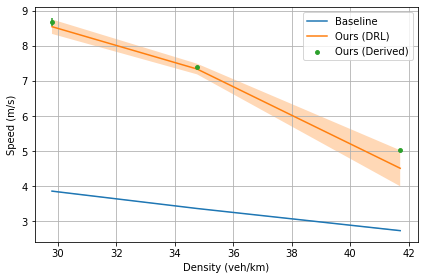

In [54]:
skip_stat_steps = 8000
fig = plt.figure(figsize=(6, 4))
densities = 14 / (radii * (4 + 3 * np.pi)) * 1000
xs = densities
for label in 'Baseline', 'Ours (DRL)', 'Ours (Derived)':
    means, stds = [], []
    for radius in radii:
        speeds = eval_paths[label, radius].load().speed
        mean, std = speeds.mean(), speeds.std()
        means.append(mean)
        stds.append(std)
    means, stds = np.array(means), np.array(stds)
    if 'Derived' in label:
        plt.errorbar(xs, means, yerr=stds, ls="none", color=f'C{color_map[i]}', zorder=100)
        plt.scatter(xs, means, label=label, color=f'C{color_map[i]}', s=15, zorder=100)
    else:
        plt.plot(xs, means, label=label)
        plt.fill_between(xs, means - stds, means + stds, alpha=0.3)
plt.grid()
plt.xlabel('Radius (m)' if xs is radii else 'Density (veh/km)')
plt.ylabel('Speed (m/s)')
plt.legend()
plt.tight_layout()
plt.show()

In [55]:
cache = {}

In [56]:
for k, path in traj_paths.items():
    if k not in cache:
        npz = path.load()
        cache[k] = trajectories = split_trajectories(pd.DataFrame({k: npz[k] for k in npz.files}), 10000)

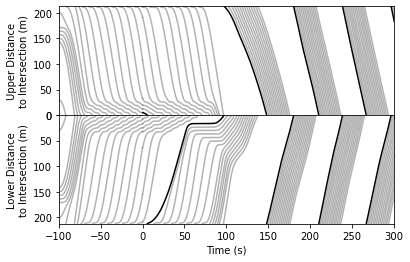

In [57]:
radius = 30
label = 'Ours (DRL)'
dfs = cache[label, radius]
vehinfo_path = traj_paths[label, radius]
xml = E.from_path(vehinfo_path.replace('.npz', '.net.xml'))
lanes = {e[0].id: Namespace(**e[0]) for e in xml if e._name == 'edge'}
lane_orders = [
    [':center_1_0', 'e_center_top_0', ':top_0_0', 'e_top_right_0', ':right_0_0', 'e_right_center_0'],
    [':center_0_0', 'e_center_left_0', ':left_0_0', 'e_left_bottom_0', ':bottom_0_0', 'e_bottom_center_0'],
]
df = dfs[0]
df.id = df.id.astype(int)
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(6, 4))
for ax, lane_order, ylabel in zip(axes, lane_orders, ('Upper', 'Lower')):
    lane_lengths = [float(lanes[k].length) for k in lane_order]
    total_length = sum(lane_lengths)
    pos_offset = dict(zip(lane_order, np.cumsum(lane_lengths) - lane_lengths))

    df['is_warmup'] = df.step < warmup_steps
    for (id, is_warmup), vehs in df.loc[df.lane_id.isin(lane_order)].groupby(['id', 'is_warmup']):
        position = vehs.apply(lambda row: pos_offset[row.lane_id] + row.lane_position, axis=1).values
        breaks = position[:-1] > position[1:]
        idxs, = breaks.nonzero()
        for steps, pos in zip(np.split(vehs.step, 1 + idxs), np.split(position, 1 + idxs)):
            ax.plot((steps - warmup_steps) * sim_step, total_length - pos, color='black', alpha=1 if id == 0 and not is_warmup else 0.3)
    ax.set_ylabel(f'{ylabel} Distance\nto Intersection (m)')
    ax.set_ylim([0, total_length])
axes[1].invert_yaxis()
plt.xlabel('Time (s)')
plt.xlim([-warmup_steps * sim_step, 300])
plt.subplots_adjust(hspace=0)
plt.show()

# Highway Bottleneck

In [58]:
HighwayBottleneckPlots = Results / 'highway_bottleneck/plots'
def highway_bottleneck_key(path):
    method, inflow = re.match('(.+) inflow=(\d+)', path.name).groups()
    return method, int(inflow)
eval_paths, traj_paths = load_results(HighwayBottleneckPlots, highway_bottleneck_key)

inflows = np.arange(1700, 2601, 100)
sim_step = 0.5
warmup_steps = 1000

In [59]:
cache = {}

In [60]:
for k, path in traj_paths.items():
    if k not in cache:
        npz = path.load()
        cache[k] = trajectories = split_trajectories(pd.DataFrame({k: npz[k] for k in npz.files}), 6000)
        assert len(trajectories) == 10

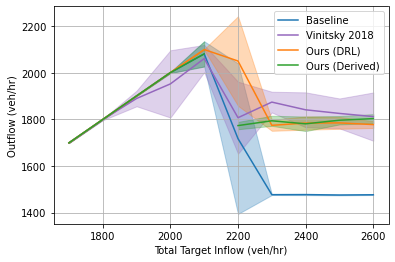

In [61]:
skip_stat_steps = 3000
xs = np.arange(1700, 2601, 100)
for i, label in enumerate(['Baseline', 'Vinitsky 2018', 'Ours (DRL)', 'Ours (Derived)']):
    means = []
    stds = []
    for flow in xs:
        dfs = [df.loc[df.step >= warmup_steps + skip_stat_steps] for df in cache[label, flow]]
        outflows = np.array([len(df.id.unique()) - len(df.id[df.step == 6000].unique()) for df in dfs])
        outflows_per_hour = outflows / sim_step / (6000 - warmup_steps - skip_stat_steps) * 3600
        means.append(outflows_per_hour.mean())
        stds.append(outflows_per_hour.std())
    means, stds = np.array(means), np.array(stds)
    color = ['C0', 'C4', 'C1', 'C2'][i]
    if 'Derived' in label:
        mask = xs < 2200
        plt.plot(xs[mask], means[mask], label=label, color=color)
        plt.fill_between(xs[mask], (means - stds)[mask], (means + stds)[mask], alpha=0.3, color=color)
        mask = ~mask
        plt.plot(xs[mask], means[mask], color=color)
        plt.fill_between(xs[mask], (means - stds)[mask], (means + stds)[mask], alpha=0.3, color=color)
    else:
        plt.plot(xs, means, label=label, color=color)
        plt.fill_between(xs, means - stds, means + stds, alpha=0.3, color=color)
plt.xlabel('Total Target Inflow (veh/hr)')
plt.ylabel('Outflow (veh/hr)')
plt.legend()
plt.grid()
plt.show()

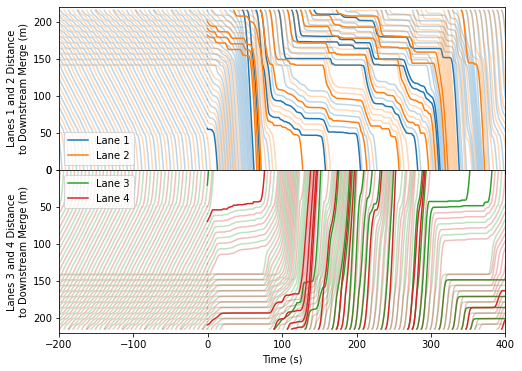

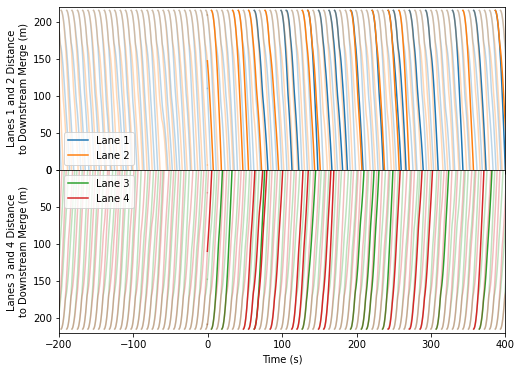

In [62]:
xml = E.from_path(traj_paths['Baseline', 2000].replace('.npz', '.net.xml'))
edges = {e.id: Namespace(**e) for e in xml if e._name == 'edge'}
lanes = {lane.id: Namespace(**lane) for e in xml for lane in e if e._name == 'edge'}
edge_order = ['e_0', ':n_1_0', 'e_1', ':n_2_0', 'e_2']
edge_lengths = [float(lanes[f'{e}_0'].length) for e in edge_order]
edge_pos_offset = dict(zip(edge_order, np.cumsum(edge_lengths) - edge_lengths))
total_length = sum(edge_lengths) - edge_lengths[-1]
lane_pos_offset = {lane: edge_pos_offset[lane.rsplit('_', 1)[0]] for lane in lanes}
lane_orders = [[f'{e}_{i}' for es, i in [(edge_order[:2], i), (edge_order[2: 4], n // 2), (edge_order[4:], n // 4)] for e in es] for n in range(4)]

x_min, x_max = [-200, 400]
label = 'Ours (DRL)'
for flow in [2400, 2000]:
    labeled = {}
    df = cache[label, flow][0]
    fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 6))
    veh_to_lane = {}
    for _, row in df.iterrows():
        veh_to_lane.setdefault(row['id'], row['lane_id'])
    df['done_warmup'] = df.step >= warmup_steps
    last_xy = {}
    for (veh_id, done_warmup), veh_group in df.groupby(['id', 'done_warmup']):
        veh_type = veh_group.type.iloc[0]
        lane_index = int(veh_to_lane[veh_id][-1])
        lane_order = lane_orders[lane_index]
        alpha = 0.3 if not done_warmup else dict(rl=1, human=0.3)[veh_type]
        color = f'C{lane_index}'
        ax = axes[lane_index // 2]
        steps = veh_group.step.values
        position = veh_group.apply(lambda row: lane_pos_offset[row.lane_id] + row.lane_position, axis=1).values
        if done_warmup:
            if veh_id in last_xy:
                last_step, last_pos = last_xy[veh_id]
                steps = np.array([last_step, *steps])
                position = np.array([last_pos, *position])
        else:
            last_xy[veh_id] = steps[-1], position[-1]
        xs = (steps - warmup_steps) * sim_step
        if xs.max() < x_min or xs.min() >= x_max:
            continue
        legend_label = None
        if lane_index not in labeled and alpha == 1:
            labeled[lane_index] = legend_label = f'Lane {lane_index + 1}'
        ax.plot(xs, total_length - position, alpha=alpha, color=color, label=legend_label)
    for ax, axlabel in zip(axes, ('Lanes 1 and 2', 'Lanes 3 and 4')):
        ax.set_ylim([0, total_length])
        ax.set_ylabel(f'{axlabel} Distance\nto Downstream Merge (m)')
    axes[0].legend(loc='lower left')
    axes[1].legend(loc='upper left')
    axes[1].invert_yaxis()
    plt.xlabel('Time (s)')
    plt.subplots_adjust(hspace=0)
    plt.xlim([x_min, x_max])
    plt.show()

## IDM parameters

In [86]:
HighwayBottleneckIdmTable = Results / 'highway_bottleneck/table_idm_parameters'
def highway_bottleneck_idm_table_key(path):
    method, idm_params, inflow = re.match('(\w+) (.+) inflow=(\d+)', path.name).groups()
    return method, idm_params, int(inflow)
eval_paths, traj_paths = load_results(HighwayBottleneckIdmTable, highway_bottleneck_idm_table_key)

In [ ]:
table = {}
for k, p in eval_paths.items():
    outflows_per_hour = p.load().outflow_hourly
    mean = outflows_per_hour.mean()
    std = outflows_per_hour.std()
    table[k] = f'{mean:.0f} ± {std:.0f}'
df = pd.Series(table).unstack()

In [90]:
categories = defaultdict(set)
for _, label, _ in eval_paths:
    if label == 'Default': continue
    keys, values = zip(*[x.split('=') for x in label.split(' ')])
    values = tuple(map(str2num, values))
    key, value = (keys, values) if len(keys) > 1 else (keys[0], values[0])
    categories[key].add((value, label))
categories['a', 'b'].add(((2.6, 4.5), 'Default'))
categories[r'\tau'].add((1, 'Default'))
categories['s_0'].add((2.5, 'Default'))
categories['v_0'].add((30, 'Default'))
categories[r'\delta'].add((4, 'Default'))
for cat, cat_set in categories.items():
    df_cat = pd.Series({
        (str(value) + ' (Default)' * (label == 'Default'), method): df.loc[(method, label), 2600]
    for value, label in sorted(cat_set) for method in [
        'Baseline',
        'Derived',
    ]}).unstack().T
    display(df_cat)

,2,3,4 (Default),5
Baseline,1458 ± 2,1473 ± 2,1476 ± 2,1478 ± 2
Derived,1724 ± 17,1773 ± 26,1787 ± 26,1791 ± 24


,15,20,25,30 (Default)
Baseline,1463 ± 3,1474 ± 2,1475 ± 3,1476 ± 2
Derived,1679 ± 13,1750 ± 31,1782 ± 20,1787 ± 26


,"(1, 1.5)","(2, 3)","(2.6, 4.5) (Default)"
Baseline,1476 ± 3,1476 ± 2,1476 ± 2
Derived,1619 ± 27,1779 ± 24,1787 ± 26


,0.5,0.75,1 (Default),1.25
Baseline,1696 ± 222,1540 ± 1,1476 ± 2,1456 ± 3
Derived,2040 ± 30,1953 ± 19,1787 ± 26,1632 ± 15


,2,2.5 (Default),3
Baseline,1514 ± 2,1476 ± 2,1440 ± 1
Derived,1843 ± 28,1787 ± 26,1736 ± 17


# Highway Ramp

In [92]:
HighwayRampPlots = Results / 'highway_ramp/plots'
def highway_ramp_key(path):
    method, highway_inflow = re.match('(.+) highway_inflow=(\d+)', path.name).groups()
    return method, int(highway_inflow)
eval_paths, traj_paths = load_results(HighwayRampPlots, highway_ramp_key)

inflows = range(1800, 2201, 100)
sim_step = 0.5
warmup_steps = 1000

In [93]:
cache = {}

In [94]:
for k, path in traj_paths.items():
    if k not in cache:
        npz = path.load()
        cache[k] = trajectories = split_trajectories(pd.DataFrame({k: npz[k] for k in npz.files}), 6000)
        assert len(trajectories) == 10

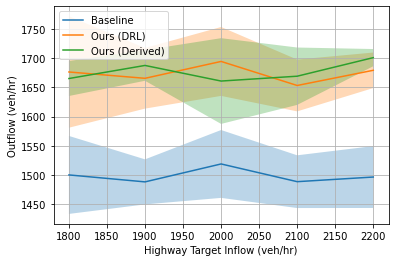

In [95]:
skip_stat_steps = 3000
xs = np.arange(1800, 2201, 100)
for label in ['Baseline', 'Ours (DRL)', 'Ours (Derived)']:
    means = []
    stds = []
    for flow in xs:
        dfs = [df.loc[df.step >= warmup_steps + skip_stat_steps] for df in cache[label, flow]]
        outflows = np.array([len(df.id.unique()) - len(df.id[df.step == 6000].unique()) for df in dfs])
        outflows_per_hour = outflows / sim_step / (6000 - warmup_steps - skip_stat_steps) * 3600
        means.append(outflows_per_hour.mean())
        stds.append(outflows_per_hour.std())
    means = np.array(means)
    plt.plot(xs, means, label=label)
    plt.fill_between(xs, means - stds, means + stds, alpha=0.3)
plt.xlabel('Highway Target Inflow (veh/hr)')
plt.ylabel('Outflow (veh/hr)')
plt.legend()
plt.grid()
plt.show()

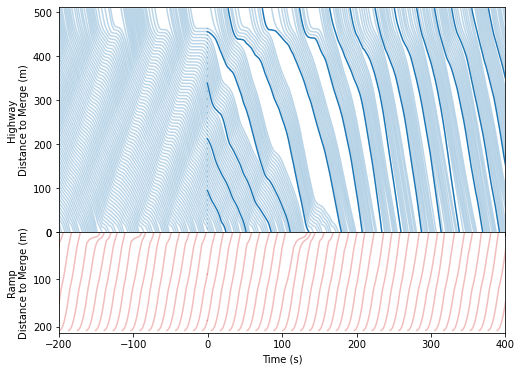

In [96]:
hwy_order = [
    'e_n_0.0_n_400.0_0',
    ':n_400.0_1_0',
    'e_n_400.0_n_500.0_1',
    ':n_500.0_0_1',
    'e_n_500.0_n_530.0_0'
]
ramp_order = [
    'e_n_329.28932188134524.-70.71067811865474_n_400.0_0',
    ':n_400.0_0_0',
    'e_n_400.0_n_500.0_0',
    ':n_500.0_0_0',
    'e_n_500.0_n_530.0_0'
]
xml = E.from_path(traj_paths['Baseline', 1800].replace('.npz', '.net.xml'))
edges = {e.id: Namespace(**e) for e in xml if e._name == 'edge'}
lanes = {lane.id: Namespace(**lane) for e in xml for lane in e if e._name == 'edge'}
lane_merge_offsets = {}
total_lengths = []
for order in hwy_order, ramp_order:
    lengths = [float(lanes[lane_id].length) for lane_id in order]
    pos_offset = np.cumsum(lengths) - lengths
    total_length = sum(lengths)
    lane_merge_offsets.update(dict(zip(order, total_length - pos_offset)))
    total_lengths.append(total_length)

flow = 1800
label = 'Ours (DRL)'
x_min, x_max = -200, 400
dfs = cache[label, flow]
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 6), gridspec_kw={'height_ratios': total_lengths})
df = dfs[1]
df['done_warmup'] = df.step >= warmup_steps
last_xy = {}
for (veh_id, done_warmup), veh_group in df.groupby(['id', 'done_warmup']):
    veh_type = veh_group.type.iloc[0]
    on_ramp = int(veh_group.lane_id.iloc[0] in ramp_order)
    alpha = 0.3 if not done_warmup else dict(rl=1, human=0.3)[veh_type]
    color = 'C3' if on_ramp else 'C0'
    ax = axes[on_ramp]
    steps = veh_group.step.values
    position = veh_group.apply(lambda row: lane_merge_offsets[row.lane_id] - row.lane_position, axis=1).values
    if done_warmup:
        if veh_id in last_xy:
            last_step, last_pos = last_xy[veh_id]
            steps = np.array([last_step, *steps])
            position = np.array([last_pos, *position])
    else:
        last_xy[veh_id] = steps[-1], position[-1]
    xs = (steps - warmup_steps) * sim_step
    if xs.max() < x_min or xs.min() >= x_max:
        continue
    ax.plot(xs, position - lengths[-1], alpha=alpha, color=color)
for ax, label, length in zip(axes, ('Highway', 'Ramp'), total_lengths):
    ax.set_ylim([0, length - lengths[-1]])
    ax.set_ylabel(f'{label}\nDistance to Merge (m)')
axes[1].set_yticks([0, 100, 200])
axes[1].invert_yaxis()
plt.xlabel('Time (s)')
plt.subplots_adjust(hspace=0)
# axes[0].set_title(f'{label} Highway Flow {flow}')
plt.xlim([x_min, x_max])
plt.show()

# Intersection

In [97]:
IntersectionPlots = Results / 'intersection/plots'
def intersection_key(path):
    method, hinflow, vinflow = re.match('(.+) horizontal_inflow=(\d+) vertical_inflow=(\d+)', path.name).groups()
    return method, int(hinflow), int(vinflow)
eval_paths, traj_paths = load_results(IntersectionPlots, intersection_key)

sim_step = 0.5
warmup_steps = 1000
flows = [(x, y) for x, y in product(*[[400, 550, 700, 850, 1000]] * 2) if x + y >= 1400 and x <= y]

In [98]:
cache = {}

In [100]:
for k, path in traj_paths.items():
    if k not in cache:
        npz = path.load()
        cache[k] = trajectories = split_trajectories(pd.DataFrame({k: npz[k] for k in npz.files}), 6000)
        assert len(trajectories) == 10

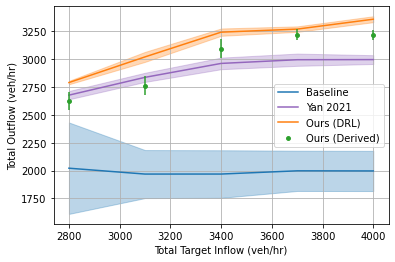

In [101]:
skip_stat_steps = 3000
labels = [
    'Baseline',
    'Yan 2021',
    'Ours (DRL)',
    'Ours (Derived)',
]
linestyles = ['-', (0, (3, 2, 1, 2)), (0, (1, 2))]
flowvs = np.arange(700, 1001, 150)[::-1]
for i, label in enumerate(labels):
    xs, means, stds = [], [], []
    for total_inflow, group in pd.Series(flows).groupby(list(map(sum, flows))):
        all_outflows_per_hour = []
        for flowh, flowv in group:
            dfs = [df.loc[df.step >= warmup_steps + skip_stat_steps] for df in cache[label, flowh, flowv]]
            outflows = np.array([len(df.id.unique()) - len(df.id[df.step == 6000].unique()) for df in dfs])
            outflows_per_hour = outflows / sim_step / (6000 - warmup_steps - skip_stat_steps) * 3600
            all_outflows_per_hour.append(outflows_per_hour)
        outflows_per_hour = np.concatenate(all_outflows_per_hour)
        mean, std = outflows_per_hour.mean(), outflows_per_hour.std()
        means.append(mean)
        stds.append(std)
        xs.append(total_inflow * 2)
    means, stds = np.array(means), np.array(stds)
    color = ['C0', 'C4', 'C1', 'C2'][i]
    if 'Derived' in label:
        plt.errorbar(xs, means, yerr=stds, ls="none", zorder=100, color=color)
        plt.scatter(xs, means, label=label, s=15, zorder=100, color=color)
    else:
        plt.plot(xs, means, label=label, color=color)
        plt.fill_between(xs, means - stds, means + stds, alpha=0.3, color=color)
plt.legend()
plt.xlabel('Total Target Inflow (veh/hr)')
plt.ylabel('Total Outflow (veh/hr)')
plt.grid()
plt.show()

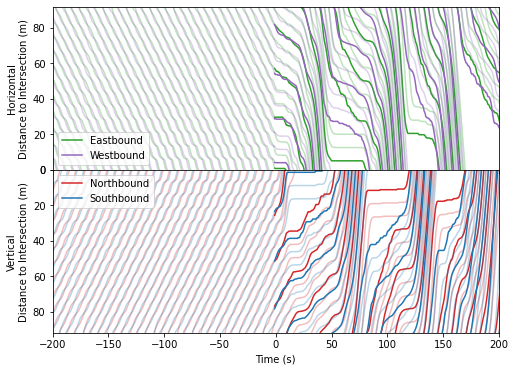

In [103]:
def plot_time_space(vehicle_info, xml, colors=['C3', 'C2', 'C0', 'C4'], max_step=600, figsize=(15, 8), figname=None):
    warmup_steps = 1000
    edges = [Namespace(**e) for e in xml if e._name == 'edge']
    lanes = [Namespace(**lane) for e in xml for lane in e if e._name == 'edge']
    
    jun_lanes = [l for l in lanes if l.id.startswith(':')]
    jun_lane_ids = [l.id for l in jun_lanes]
    in_edges, in_lanes = zip(*[(edge, lane) for edge, lane in zip(edges, lanes) if edge.get('to') == 'n_100.100'])
    in_edge_ids = [e.id for e in in_edges]
    in_lane_ids = [l.id for l in in_lanes]
    
    def parse_xy(s, number='(\d+)', sep='.'):
        return [(float(x), float(y)) for x, y in re.findall(f'{number}{sep}{number}', s)]
    
    def get_direction(xy1, xy2):
        (x1, y1), (x2, y2) = xy1, xy2
        direction = (int(np.sign(x2 - x1)), int(np.sign(y2 - y1)))
        return {(0, 1): 'Northbound', (0, -1): 'Southbound', (1, 0): 'Eastbound', (-1, 0): 'Westbound'}[direction]
    
    directions = {jl.id: get_direction(*parse_xy(jl.shape, number='([\d\.]+)', sep=',')) for jl in jun_lanes}       
    directions.update((l_i, get_direction(*parse_xy(l_i))) for l_i in in_lane_ids)
    hor = ['Westbound', 'Eastbound']
    
    intersection_info = vehicle_info.loc[vehicle_info.lane_id.isin(directions)]
    intersection_info['direction'] = intersection_info.lane_id.apply(directions.get)
    intersection_info['internal'] = intersection_info.lane_id.apply(lambda x: x.startswith(':'))
    
    start = intersection_info.step.min()
    intersection_info_trunc = intersection_info[intersection_info.step < start + max_step]
    end = intersection_info_trunc.step.max() + 1
    sim_step = 0.5
    L = 100
    labeled = {}
    fig, axes = plt.subplots(2, 1, figsize=figsize, sharex=True)
    for direction, dir_group in intersection_info_trunc.groupby('direction'):
        ax = axes[0 if direction in hor else 1]
        dir_group['is_warmup'] = dir_group.step < warmup_steps
        for (veh_id, is_warmup), veh_group in dir_group.groupby(['id', 'is_warmup']):
            veh_type = veh_group.type.iloc[0]
            step = (veh_group.step - start).values
            
            space = veh_group.apply(lambda row: row.lane_position + (100 if row.internal else 0), axis=1).values
            
            if (space > 100).all():
                continue
            if (space > 100).any():
                i_end = np.argmax(space > 100)
                t_100 = step[i_end] - (space[i_end] - 100) / (space[i_end] - space[i_end - 1])
                assert 100 > space[i_end - 1]
                assert t_100 > step[i_end - 1]
                space = np.concatenate((space[:i_end], [100]))
                step = np.concatenate((step[:i_end], [t_100]))
            
            linestyle = '-'
            alpha = 0.3 if is_warmup else dict(human=0.3, rl=1)[veh_type]
            color = dict(zip(['Northbound', 'Eastbound', 'Southbound', 'Westbound'], colors))[direction]
            label = None
            if direction not in labeled and not is_warmup and veh_type == 'rl':
                labeled[direction] = label = direction
            ax.plot((step - warmup_steps) * sim_step, 100 - space, color=color, linestyle=linestyle, alpha=alpha, label=label)
    topax, botax = axes
    for ax in axes:
        ax.set_ylim([0, 92])
    botax.invert_yaxis()
    plt.xlim([-200, 200])
    plt.xlabel('Time (s)')
    topax.set_ylabel('Horizontal\nDistance to Intersection (m)', wrap=True)
    botax.set_ylabel('Vertical\nDistance to Intersection (m)', wrap=True)
    plt.subplots_adjust(hspace=0)
    topax.legend(loc='lower left')
    botax.legend(loc='upper left')
    plt.show()

key = label, flowh, flowv = 'Ours (DRL)', 850, 850
xml = E.from_path(traj_paths[key].replace('.npz', '.net.xml'))
plot_time_space(cache[key][0], xml, figsize=(8, 6), max_step=2000)